# Preprocessing WhatsApp Google Play Reviews

Import required libraries.

In [14]:
import pandas as pd
from langdetect import detect_langs
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from utils.review_utils import get_google_play_data

## Scraping and Analyzing Data

First, scrape the reviews from the Google Play Store.

In [15]:
# Get reviews
APP_ID = 'com.whatsapp'
reviews = get_google_play_data(APP_ID)
df = pd.DataFrame(reviews)

# Print a few reviews (just the score and content)
print('Score  Content')
print('--------------')
for i in range(5):
    print(f"{df.iloc[i]['score']:<7}{df.iloc[i]['content']}")

Score  Content
--------------
1      I call this app scammer depot, because 97% of groups are just scammers trying to steal your money
5      So good
5      Goodl
5      Cool
5      Can


In [16]:
# Print number of rows in the data
rows0 = df.shape[0]
print(f'Initially there are {rows0:,} reviews')

Initially there are 328,500 reviews


The length of the reviews might give important insight into the quality of the review.

In [17]:
# Make column for word count (of the review content)
df['word_count'] = df['content'].str.split().apply(lambda s: 0 if s == None else len(s))

Plotting the distribution of the word counts of the reviews, we see that the vast majority of the reviews contain fewer than 10 words.

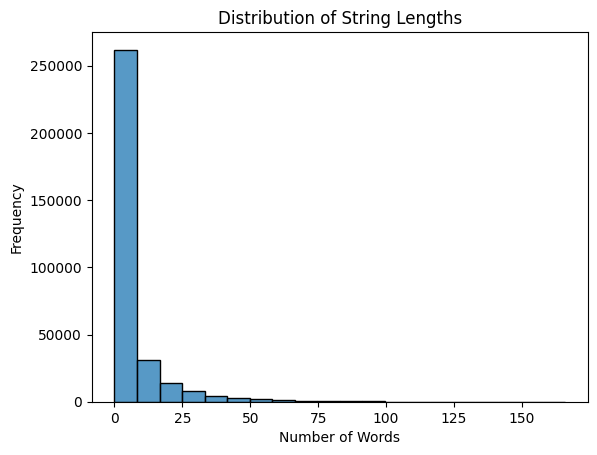

In [18]:
# Histogram of the word count of the reviews
sns.histplot(df['word_count'], bins=20)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of String Lengths')
plt.show()

## Preprocessing Step 1: Removing Short Reviews

We will remove short reviews, since they probably don't contain much useful information.

In [19]:
# Make column for word count (of the review content)
df['word_count'] = df['content'].str.split().apply(lambda s: 0 if s == None else len(s))

# Remove short reviews
REVIEW_WORD_COUNT_THRESHOLD = 10
df = df[df['word_count'] >= REVIEW_WORD_COUNT_THRESHOLD]

In [20]:
# Print number of rows in the data after filtering out short reviews
rows1 = df.shape[0]
print(f'After filtering out short reviews, we have {rows1:,} reviews (removed {rows0 - rows1:,} reviews)')

After filtering out short reviews, we have 60,538 reviews (removed 267,962 reviews)


## Preprocessing Step 2: Removing Gibberish

Upon some inspection of the data, there are many reviews that don't make sense (as in, are incomprehensible).

The `contains_gibberish` function detects whether a string of text contains gibberish.

In [21]:
def contains_gibberish(text):
    """
    Returns true if `text` contains gibberish, false otherwise.
    """
    gibberish_patterns = [
        r'(\w)\1{3,}', # Word character repeated 3 or more times
        r'\d{5,}'      # Sequence of 5 or more digits
    ]

    for pattern in gibberish_patterns:
        if re.search(pattern, text):
            return True
    return False

We apply the `contains_gibberish` function to remove reviews that contain signs of incomprehensible text.

In [22]:
# Filter out gibberish
df = df[~df['content'].apply(contains_gibberish)]

In [23]:
# Print number of rows in the data after filtering out gibberish
rows2 = df.shape[0]
print(f'After filtering out gibberish reviews, we have {rows2:,} reviews (removed {rows1 - rows2:,} reviews)')

After filtering out gibberish reviews, we have 59,922 reviews (removed 616 reviews)


## Preprocessing Step 3: Removing Non-English Reviews

There are also many reviews that are not in english.
To avoid having to translate reviews, we will just remove the non-english reviews.

The `is_english` function below uses the [langdetect](https://pypi.org/project/langdetect/) Python library to predict whether a string of text is in english.

In [24]:
LANGUAGE_PROBABILITY_THRESHOLD = 0.999
def is_english(text):
    """
    Returns true if `text` is predicted to be in english with a high
    probability, false otherwise.
    """
    try:
        # Get probabilities of the text being in certain languages
        language_probabilities = detect_langs(text)

        # If no prediction was able to be made, then assume not in english
        if len(language_probabilities) == 0:
            return False

        # Get the most likely language of the text
        most_likely_language = max(language_probabilities, key=lambda language: language.prob)

        # If the most likely language is english with a probability higher than
        # the threshold, then assume it is in english
        if most_likely_language.lang == 'en' and most_likely_language.prob > LANGUAGE_PROBABILITY_THRESHOLD:
            return True

        # Otherwise assume not in english
        return False
    except:
        # If an exception was raised during the prediction, assume not in english
        return False

Applying the `is_english` function, we see some examples of non-english reviews.

In [25]:
df_non_english = df[~(df['content'].apply(is_english))]
for i in range(5):
    print(f"{ascii(df_non_english.iloc[i]['content'])}\n")

'Mujhe ye chalane me dikkat aa rahi hai mera app open nahi hota hai number dalne ke baad otp aane se pahle hi kuch ho jaata hai open nahi hota hai app'

'\u0db8\u0db8 \u0dc0\u0da7\u0dca\u0dc3\u0dca\u0d87\u0db4\u0dca \u0dc4\u0dd0\u0daf\u0dd4\u0dc0\u0dcf\u0da7 \u0db4\u0dc3\u0dca\u0dc3\u0dd9 \u0db8\u0db8 \u0d9c\u0ddc\u0da9\u0d9a\u0dca \u0dc3\u0dad\u0dd4\u0da7\u0dd4 \u0dc0\u0dd4\u0dab\u0dcf \u0db8\u0da7 \u0d9c\u0ddc\u0da9\u0d9a\u0dca \u0d9a\u0ddc\u0dbd\u0dca\u0dbd\u0ddc \u0dc3\u0dd9\u0da7\u0dca\u0dc0\u0dd4\u0db1\u0dcf \u0db8\u0db8 \u0d92 \u0dc4\u0dd0\u0db8\u0ddc\u0da7\u0db8 \u0d86\u0daf\u0dbb\u0dda \u0d9a\u0dbd\u0dcf\U0001f970 \u0db8\u0db8 \u0d9c\u0ddc\u0da9\u0d9a\u0dca \u0daf\u0dd0\u0db1\u0dca \u0dc3\u0dad\u0dd4\u0da7\u0dd2\u0db1\u0dca \u0d89\u0db1\u0dca\u0db1\u0dd9'

'Whastpp me ab buht msle hone lg gay na vedio open hori na voice na pics na status or nahi kuch send ho rha buht Pareeshani ho rhi he kam me plz jldi theek kren \U0001f64f\U0001f64f\U0001f64f'

'Me encata WhatsApp para extia

We apply the `is_english` function to remove these reviews.

In [26]:
# Filter out non-english reviews
df = df[df['content'].apply(is_english)]

In [27]:
# Print number of rows in the data after filtering out non-english reviews
rows3 = df.shape[0]
print(f'After filtering out non-english reviews, we have {rows3:,} reviews (removed {rows2 - rows3:,} reviews)')

After filtering out non-english reviews, we have 54,164 reviews (removed 5,758 reviews)


## Preprocessing Step 4: Splitting Reviews By Rating

It is likely that reviews that rate the app highly will have positive things to say about the app, whereas reviews with lower ratings will contain complaints about the app.
Positive reviews can be used to detect requirements that are being satisfied and negative reviews can point to ignored requirements (or new, previously unspecified requirements).

Shown below, most of the reviews are 1 star, with 5 star reviews following close behind.
Reviews with 2, 3, and 4 stars are significantly smaller in number, but when combined together have almost the same amount as the 1 and 5 star reviews.

In [28]:
# Print the counts of each rating
print(df['score'].value_counts().sort_index())

score
1    20649
2     4446
3     5089
4     5644
5    18336
Name: count, dtype: int64


In [29]:
# Split the reviews into negative (1 star), mixed (2, 3, and 4 stars), and
# positive (5 stars)
df_negative = df[df['score'] == 1]
df_mixed = df[(df['score'] == 2) | (df['score'] == 3) | (df['score'] == 4)]
df_positive = df[df['score'] == 5]

Shown below, the 1 star reviews are mostly negative,

In [30]:
for i in range(5):
    print(f"{df_negative.iloc[i]['content']}\n")

I call this app scammer depot, because 97% of groups are just scammers trying to steal your money

due to * ask meta al" instead of "Search" option

This app is really annoying how can u claim to be good when u allow people to spam user with virus and u haven't done anything about it honestly I'm ashamed

Please provide sending option more than five times,it should be unlimited. Text status in urdu break the sequence of sentences kindly eliminate this problem.

I don't have meta ai yet and I have updated and cleared my storage



the 2, 3, and 4 star reviews are mixed,

In [31]:
for i in range(5):
    print(f"{df_mixed.iloc[i]['content']}\n")

Recently I've been having a lot of problems getting photos and videos to play/download while using data. I don't understand why that is when I have a perfectly fine working package. I hope you guys can fix this cuz it's getting quite annoying.

Suddenly can use Lock chats. The pull down so you can view isn't working. It was perfectly. Hiding messages for a surprise birthday party is great but can't access then unless someone messages in that group

I start to enjoy your new features but i don't know why i have been blocked all the time. Tanx

Am tired of updating it time to time,i think this very version of whatsapp is very old

Good to use but some times its not downloading a file or pic or videos fix this



and the 5 star reviews are mostly positive.

In [32]:
for i in range(5):
    print(f"{df_positive.iloc[i]['content']}\n")

I love WhatsApp it's help me with my work today

That's good for calls and speak everyone from anywhere I thanks who makes app

It's really cool but I'll suggest they bring up the live and the tagging feature

That's great app ever. I really enjoy this application, and I don't know how to express my appreciation for this app, because I much very satisfied.

Nice ! But i think you guys should add more features to meta AI



## Saving Preprocessed Data to Files

As the last step, we will save the dataframes to CSV files so that they can be used later.

In [33]:
NOTEBOOK_PATH = Path(os.path.abspath(''))
DATA_PATH = NOTEBOOK_PATH.parent / 'data'

# Ensure data directory exists
DATA_PATH.mkdir(exist_ok=True)

In [34]:
# Save dataframes to csv files
df_negative.to_csv(DATA_PATH / 'negative_reviews.csv', index=False)
df_mixed.to_csv(DATA_PATH / 'mixed_reviews.csv', index=False)
df_positive.to_csv(DATA_PATH / 'positive_reviews.csv', index=False)